Rafael Gonçalves (186062)

In [1]:
import os
import urllib.request
import random
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
import csv
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import mlxtend

%matplotlib inline

## Download dataset

In [2]:
train_url = 'http://www.dca.fee.unicamp.br/~lboccato/dados_treinamento.mat'
validation_url = 'http://www.dca.fee.unicamp.br/~lboccato/dados_val.mat'
test_url = 'http://www.dca.fee.unicamp.br/~lboccato/dados_teste.mat'
data_dir = os.path.abspath(os.path.relpath('../data'))
train_path = os.path.join(data_dir, 'train.mat')
validation_path = os.path.join(data_dir, 'validation.mat')
test_path = os.path.join(data_dir, 'test.mat')
image_dir = os.path.abspath(os.path.relpath('../doc/images'))

urllib.request.urlretrieve(train_url, train_path)
urllib.request.urlretrieve(validation_url, validation_path)
urllib.request.urlretrieve(test_url, test_path)

('/home/rafael/inbox/machine-learning/3-mlp-and-svm/data/test.mat',
 <http.client.HTTPMessage at 0x7f42a6f93668>)

In [3]:
train_set = scipy.io.loadmat(train_path)
val_set = scipy.io.loadmat(validation_path)
test_set = scipy.io.loadmat(test_path)

In [4]:
X_train = train_set["X"]
y_train = train_set["y"]
X_val = val_set["Xval"]
y_val = val_set["yval"]
X_test = test_set["Xt"]
y_test = test_set["yt"]

In [5]:
y_train[y_train == -1] = 0
y_val[y_val == -1] = 0
y_test[y_test == -1] = 0

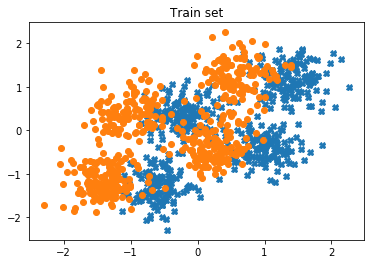

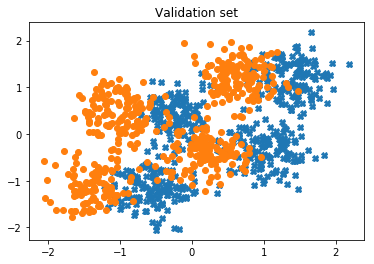

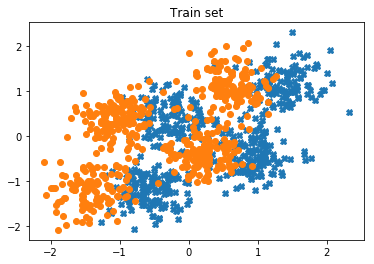

In [6]:
plt.plot(X_train[np.in1d(y_train, 1), 0], X_train[np.in1d(y_train, 1), 1], 'X')
plt.plot(X_train[np.in1d(y_train, 0), 0], X_train[np.in1d(y_train, 0), 1], 'o')
plt.title("Train set")
plt.show()
plt.plot(X_val[np.in1d(y_val, 1), 0], X_val[np.in1d(y_val, 1), 1], 'X')
plt.plot(X_val[np.in1d(y_val, 0), 0], X_val[np.in1d(y_val, 0), 1], 'o')
plt.title("Validation set")
plt.show()
plt.title("Train set")
plt.plot(X_test[np.in1d(y_test, 1), 0], X_test[np.in1d(y_test, 1), 1], 'X')
plt.plot(X_test[np.in1d(y_test, 0), 0], X_test[np.in1d(y_test, 0), 1], 'o')
plt.show()

# 1 - Multilayer Perceptron (MLP)

In [16]:
C = 1 # number of classes
D_in = 2 # dimension of input
learning_rate = 0.1
epochs = 50
show_step = 5

In [24]:
H = 10

for learning_rate in [10, 1, 0.1, 0.01, 0.001]:

    model = torch.nn.Sequential(
        torch.nn.Linear(D_in, H),
        torch.nn.ReLU(),
        torch.nn.Linear(H, C),
        torch.nn.Sigmoid(),
    )

    optimizer = optim.SGD(model.parameters(), lr=learning_rate)

    model.train()
    for epoch in range(epochs):
        for idx, (x, y) in enumerate(zip(torch.tensor(X_train, dtype=torch.float),
                                         torch.tensor(y_train, dtype=torch.float))):
            optimizer.zero_grad()
            output = model(x)
            loss = F.binary_cross_entropy(output, y, reduction="mean")
            loss.backward()
            optimizer.step()
        if epoch % show_step == 0:
            print('Train Epoch: {} Loss: {:.6f}'.format(epoch, loss.item()))

Train Epoch: 0 Loss: 27.631021
Train Epoch: 5 Loss: 27.631021
Train Epoch: 10 Loss: 27.631021
Train Epoch: 15 Loss: 27.631021
Train Epoch: 20 Loss: 27.631021
Train Epoch: 25 Loss: 27.631021
Train Epoch: 30 Loss: 27.631021
Train Epoch: 35 Loss: 27.631021
Train Epoch: 40 Loss: 27.631021
Train Epoch: 45 Loss: 27.631021
Train Epoch: 0 Loss: 1.024595
Train Epoch: 5 Loss: 1.098306
Train Epoch: 10 Loss: 1.024595
Train Epoch: 15 Loss: 1.024595
Train Epoch: 20 Loss: 1.024595
Train Epoch: 25 Loss: 1.024595
Train Epoch: 30 Loss: 1.024595
Train Epoch: 35 Loss: 1.024595
Train Epoch: 40 Loss: 1.024595
Train Epoch: 45 Loss: 1.024595
Train Epoch: 0 Loss: 1.033838
Train Epoch: 5 Loss: 0.256586
Train Epoch: 10 Loss: 0.241802
Train Epoch: 15 Loss: 0.238776
Train Epoch: 20 Loss: 0.211681
Train Epoch: 25 Loss: 0.211222
Train Epoch: 30 Loss: 0.210146
Train Epoch: 35 Loss: 0.201475
Train Epoch: 40 Loss: 0.211884
Train Epoch: 45 Loss: 0.211758
Train Epoch: 0 Loss: 0.872756
Train Epoch: 5 Loss: 0.866719
Train 

H =  3
Train Epoch: 0 Loss: 0.668694
Train Epoch: 5 Loss: 0.976015
Train Epoch: 10 Loss: 0.911896
Train Epoch: 15 Loss: 0.855713
Train Epoch: 20 Loss: 0.706917
Train Epoch: 25 Loss: 0.675351
Train Epoch: 30 Loss: 0.693855
Train Epoch: 35 Loss: 0.701797
Train Epoch: 40 Loss: 0.703798
Train Epoch: 45 Loss: 0.702680

Validation set: Avg. loss: 0.4346, Accuracy: 719/1000 (72%)



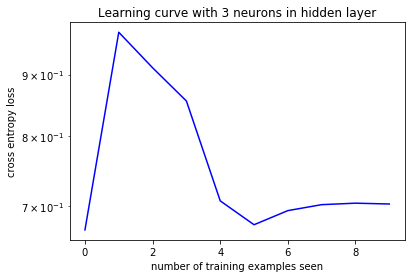

H =  6
Train Epoch: 0 Loss: 0.769963
Train Epoch: 5 Loss: 0.787907
Train Epoch: 10 Loss: 0.730002
Train Epoch: 15 Loss: 0.560815
Train Epoch: 20 Loss: 0.357564
Train Epoch: 25 Loss: 0.207953
Train Epoch: 30 Loss: 0.154241
Train Epoch: 35 Loss: 0.131396
Train Epoch: 40 Loss: 0.120858
Train Epoch: 45 Loss: 0.114953

Validation set: Avg. loss: 0.3188, Accuracy: 865/1000 (86%)



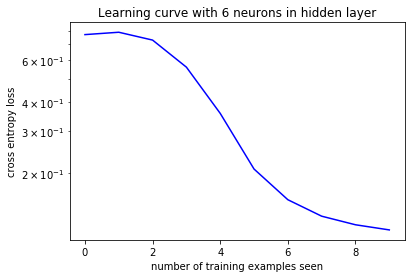

H =  10
Train Epoch: 0 Loss: 0.846543
Train Epoch: 5 Loss: 0.933741
Train Epoch: 10 Loss: 0.801368
Train Epoch: 15 Loss: 0.720030
Train Epoch: 20 Loss: 0.689292
Train Epoch: 25 Loss: 0.659627
Train Epoch: 30 Loss: 0.639544
Train Epoch: 35 Loss: 0.584384
Train Epoch: 40 Loss: 0.411269
Train Epoch: 45 Loss: 0.291879

Validation set: Avg. loss: 0.3262, Accuracy: 869/1000 (87%)



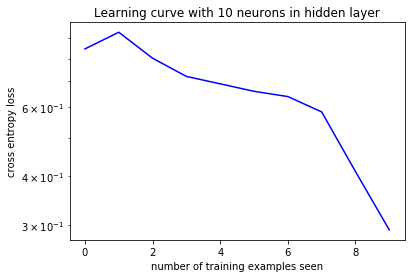

H =  30
Train Epoch: 0 Loss: 1.000407
Train Epoch: 5 Loss: 0.872229
Train Epoch: 10 Loss: 0.504290
Train Epoch: 15 Loss: 0.252899
Train Epoch: 20 Loss: 0.163134
Train Epoch: 25 Loss: 0.127091
Train Epoch: 30 Loss: 0.111410
Train Epoch: 35 Loss: 0.103254
Train Epoch: 40 Loss: 0.099119
Train Epoch: 45 Loss: 0.098200

Validation set: Avg. loss: 0.2876, Accuracy: 881/1000 (88%)



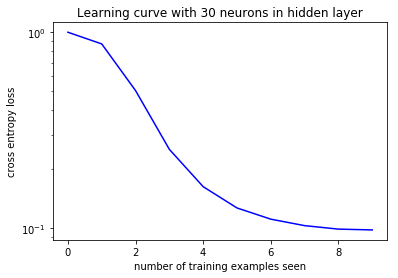

H =  60
Train Epoch: 0 Loss: 0.982140
Train Epoch: 5 Loss: 0.768198
Train Epoch: 10 Loss: 0.431733
Train Epoch: 15 Loss: 0.237979
Train Epoch: 20 Loss: 0.167255
Train Epoch: 25 Loss: 0.134218
Train Epoch: 30 Loss: 0.118243
Train Epoch: 35 Loss: 0.108593
Train Epoch: 40 Loss: 0.104366
Train Epoch: 45 Loss: 0.102708

Validation set: Avg. loss: 0.2819, Accuracy: 879/1000 (88%)



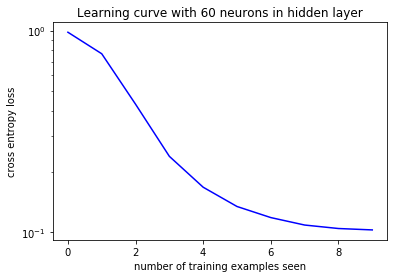

H =  100
Train Epoch: 0 Loss: 1.083025
Train Epoch: 5 Loss: 0.655313
Train Epoch: 10 Loss: 0.315973
Train Epoch: 15 Loss: 0.180335
Train Epoch: 20 Loss: 0.127750
Train Epoch: 25 Loss: 0.104839
Train Epoch: 30 Loss: 0.094047
Train Epoch: 35 Loss: 0.088808
Train Epoch: 40 Loss: 0.085811
Train Epoch: 45 Loss: 0.084189

Validation set: Avg. loss: 0.2789, Accuracy: 882/1000 (88%)



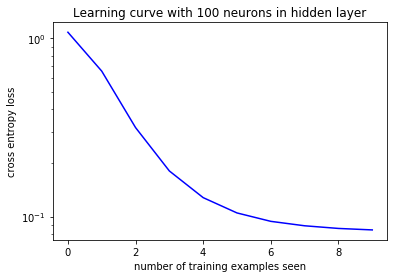

In [40]:
learning_rate = 0.01
epochs = 100
for H in [3, 6, 10, 30, 60, 100]:
    print("H = ", H)
    train_losses = []
    val_losses = []
    
    model = torch.nn.Sequential(
        torch.nn.Linear(D_in, H),
        torch.nn.ReLU(),
        torch.nn.Linear(H, C),
        torch.nn.Sigmoid(),
    )
    
    optimizer = optim.SGD(model.parameters(), lr=learning_rate)
    
    model.train()
    for epoch in range(epochs):
        for idx, (data, target) in enumerate(zip(torch.tensor(X_train, dtype=torch.float),
                                         torch.tensor(y_train, dtype=torch.float))):
            optimizer.zero_grad()
            output = model(data)
            loss = F.binary_cross_entropy(output, target)
            loss.backward()
            optimizer.step()
        if epoch % show_step == 0:
            print('Train Epoch: {} Loss: {:.6f}'.format(epoch, loss.item()))
            train_losses.append(loss.item())        
    
    model.eval()
    val_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in zip(torch.tensor(X_train, dtype=torch.float),
                                         torch.tensor(y_train, dtype=torch.float)):
            output = model(data)
            val_loss += F.binary_cross_entropy(output, target, size_average=False).item()
            pred = torch.round(output)
            correct += (1 if pred == target else 0)
    val_loss /= len(y_val)
    val_losses.append(val_loss)
    print('\nValidation set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    val_loss, correct, len(y_val),
    100. * correct / len(y_val)))
    
    plt.plot(train_losses, color='blue')
    plt.yscale("log")
    #plt.scatter(test_counter, test_losses, color='red')
    plt.title('Learning curve with {} neurons in hidden layer'.format(H))
    #plt.legend(['Train Loss', 'Validation Loss'], loc='upper right')
    plt.xlabel('number of training examples seen')
    plt.ylabel('cross entropy loss')
    plt.show()

H =  3
Epoch: 0 Validation set: Avg. loss: 0.6215, Accuracy: 586/1000 (59%)

Epoch: 10 Validation set: Avg. loss: 0.5596, Accuracy: 678/1000 (68%)

Epoch: 20 Validation set: Avg. loss: 0.5504, Accuracy: 661/1000 (66%)

Epoch: 30 Validation set: Avg. loss: 0.5443, Accuracy: 662/1000 (66%)

Epoch: 40 Validation set: Avg. loss: 0.5426, Accuracy: 669/1000 (67%)

Epoch: 50 Validation set: Avg. loss: 0.5421, Accuracy: 671/1000 (67%)

Epoch: 60 Validation set: Avg. loss: 0.5417, Accuracy: 672/1000 (67%)

Epoch: 70 Validation set: Avg. loss: 0.5331, Accuracy: 677/1000 (68%)

Epoch: 80 Validation set: Avg. loss: 0.5134, Accuracy: 695/1000 (70%)

Epoch: 90 Validation set: Avg. loss: 0.5030, Accuracy: 715/1000 (72%)



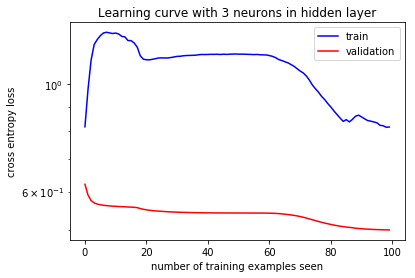

H =  6
Epoch: 0 Validation set: Avg. loss: 0.6540, Accuracy: 637/1000 (64%)

Epoch: 10 Validation set: Avg. loss: 0.4799, Accuracy: 716/1000 (72%)

Epoch: 20 Validation set: Avg. loss: 0.3790, Accuracy: 811/1000 (81%)

Epoch: 30 Validation set: Avg. loss: 0.3195, Accuracy: 873/1000 (87%)

Epoch: 40 Validation set: Avg. loss: 0.2994, Accuracy: 879/1000 (88%)

Epoch: 50 Validation set: Avg. loss: 0.2935, Accuracy: 876/1000 (88%)

Epoch: 60 Validation set: Avg. loss: 0.2919, Accuracy: 876/1000 (88%)

Epoch: 70 Validation set: Avg. loss: 0.2912, Accuracy: 876/1000 (88%)

Epoch: 80 Validation set: Avg. loss: 0.2908, Accuracy: 877/1000 (88%)

Epoch: 90 Validation set: Avg. loss: 0.2905, Accuracy: 876/1000 (88%)



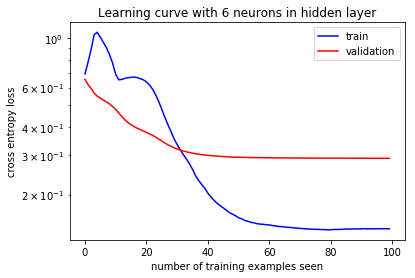

H =  10
Epoch: 0 Validation set: Avg. loss: 0.6038, Accuracy: 595/1000 (60%)

Epoch: 10 Validation set: Avg. loss: 0.5136, Accuracy: 690/1000 (69%)

Epoch: 20 Validation set: Avg. loss: 0.4566, Accuracy: 724/1000 (72%)

Epoch: 30 Validation set: Avg. loss: 0.4295, Accuracy: 768/1000 (77%)

Epoch: 40 Validation set: Avg. loss: 0.4205, Accuracy: 790/1000 (79%)

Epoch: 50 Validation set: Avg. loss: 0.4169, Accuracy: 794/1000 (79%)

Epoch: 60 Validation set: Avg. loss: 0.4153, Accuracy: 796/1000 (80%)

Epoch: 70 Validation set: Avg. loss: 0.4145, Accuracy: 798/1000 (80%)

Epoch: 80 Validation set: Avg. loss: 0.4139, Accuracy: 798/1000 (80%)

Epoch: 90 Validation set: Avg. loss: 0.4136, Accuracy: 798/1000 (80%)



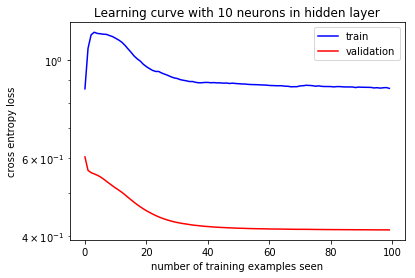

H =  30
Epoch: 0 Validation set: Avg. loss: 0.5609, Accuracy: 653/1000 (65%)

Epoch: 10 Validation set: Avg. loss: 0.4079, Accuracy: 760/1000 (76%)

Epoch: 20 Validation set: Avg. loss: 0.3117, Accuracy: 877/1000 (88%)

Epoch: 30 Validation set: Avg. loss: 0.2965, Accuracy: 875/1000 (88%)

Epoch: 40 Validation set: Avg. loss: 0.2927, Accuracy: 875/1000 (88%)

Epoch: 50 Validation set: Avg. loss: 0.2898, Accuracy: 876/1000 (88%)

Epoch: 60 Validation set: Avg. loss: 0.2875, Accuracy: 876/1000 (88%)

Epoch: 70 Validation set: Avg. loss: 0.2856, Accuracy: 875/1000 (88%)

Epoch: 80 Validation set: Avg. loss: 0.2837, Accuracy: 876/1000 (88%)

Epoch: 90 Validation set: Avg. loss: 0.2820, Accuracy: 879/1000 (88%)



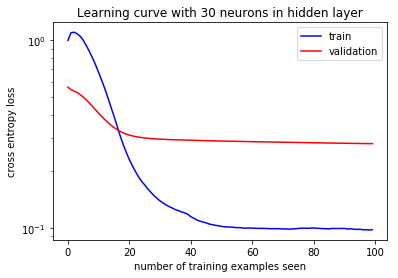

H =  60
Epoch: 0 Validation set: Avg. loss: 0.5422, Accuracy: 672/1000 (67%)

Epoch: 10 Validation set: Avg. loss: 0.3544, Accuracy: 862/1000 (86%)

Epoch: 20 Validation set: Avg. loss: 0.2981, Accuracy: 879/1000 (88%)

Epoch: 30 Validation set: Avg. loss: 0.2878, Accuracy: 878/1000 (88%)

Epoch: 40 Validation set: Avg. loss: 0.2829, Accuracy: 880/1000 (88%)

Epoch: 50 Validation set: Avg. loss: 0.2791, Accuracy: 881/1000 (88%)

Epoch: 60 Validation set: Avg. loss: 0.2763, Accuracy: 884/1000 (88%)

Epoch: 70 Validation set: Avg. loss: 0.2742, Accuracy: 885/1000 (88%)

Epoch: 80 Validation set: Avg. loss: 0.2725, Accuracy: 888/1000 (89%)

Epoch: 90 Validation set: Avg. loss: 0.2710, Accuracy: 887/1000 (89%)



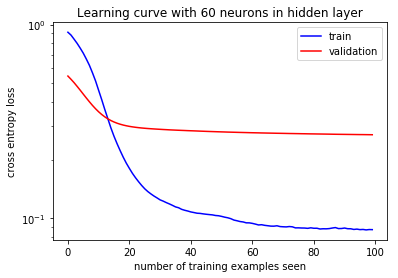

H =  100
Epoch: 0 Validation set: Avg. loss: 0.5441, Accuracy: 681/1000 (68%)

Epoch: 10 Validation set: Avg. loss: 0.3332, Accuracy: 875/1000 (88%)

Epoch: 20 Validation set: Avg. loss: 0.2907, Accuracy: 880/1000 (88%)

Epoch: 30 Validation set: Avg. loss: 0.2829, Accuracy: 880/1000 (88%)

Epoch: 40 Validation set: Avg. loss: 0.2790, Accuracy: 882/1000 (88%)

Epoch: 50 Validation set: Avg. loss: 0.2760, Accuracy: 885/1000 (88%)



In [ ]:
learning_rate = 0.01
show_step = 10
epochs = 100
for H in [3, 6, 10, 30, 60, 100]:
    print("H = ", H)
    train_losses = []
    val_losses = []
    
    model = torch.nn.Sequential(
        torch.nn.Linear(D_in, H),
        torch.nn.ReLU(),
        torch.nn.Linear(H, C),
        torch.nn.Sigmoid(),
    )
    
    optimizer = optim.SGD(model.parameters(), lr=learning_rate)
    
    model.train()
    for epoch in range(epochs):
        for idx, (data, target) in enumerate(zip(torch.tensor(X_train, dtype=torch.float),
                                         torch.tensor(y_train, dtype=torch.float))):
            optimizer.zero_grad()
            output = model(data)
            loss = F.binary_cross_entropy(output, target)
            loss.backward()
            optimizer.step()
            
        #print('Train Epoch: {} Loss: {:.6f}'.format(epoch, loss.item()))
        train_losses.append(loss.item())    
            
        model.eval()
        val_loss = 0
        correct = 0
        with torch.no_grad():
            for data, target in zip(torch.tensor(X_train, dtype=torch.float),
                                             torch.tensor(y_train, dtype=torch.float)):
                output = model(data)
                val_loss += F.binary_cross_entropy(output, target, size_average=False).item()
                pred = torch.round(output)
                correct += (1 if pred == target else 0)
        val_loss /= len(y_val)
        val_losses.append(val_loss)
        
        if epoch % show_step == 0:
            print('Epoch: {} Validation set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
                epoch,
                val_loss, correct, len(y_val),
                100. * correct / len(y_val)))

    plt.plot(train_losses, color='blue')
    plt.plot(val_losses, color='red')
    plt.legend(["train", "validation"])
    plt.yscale("log")
    plt.title('Learning curve with {} neurons in hidden layer'.format(H))
    plt.xlabel('number of training examples seen')
    plt.ylabel('cross entropy loss')
    plt.show()